30.07.2016, Pawel [alxd](https://alxd.org/) Chojnacki
# NeuroOn Hypnogram Analysis

Following my principles of Open Access and Open Notebook Science I'd like to present you my comparative analysis of NeuroOn and a professional polisomnograph recording from two nights. To learn more about the experiment itself, please head back to my [previous blog post](https://alxd.org/neuroon-analysis-sources.html).

*[more on NeuroOn and AURA PSG, make assumption that Aura is the closest thing to what is actually happening in the brain]*

At the moment of writing this I haven't been professionally involved in EEG analysis for over two years - please feel free to comment on my code and let me know if any part is unclear or may lead to wrong conclusions.

## Signal formats

All signals are available for download [here](https://obsidian.alxd.org/cloud/index.php/s/GvTLhgL8A7I8iTF), with md5sum `2ed8faecb52e027948f19d62175e02da`.

NeuroOn signal was obtained by using proprietary Intelclinic's scripts I am not allowed to share. They produced four CSV files, containing respectively:

 - EEG signal (125 Hz)
 - accelerometer signal
 - LED activity
 - Staging ([hypnogram](https://en.wikipedia.org/wiki/Hypnogram))

AURA PSG signal was exported to an EDF format using Grass Technologies PSG TWin 4.5.4 and 4.5.2 to minimize the risk of software-derived artifacts. The channels signals include:

 - EOG1-A1
 - EOG2-A1
 - CHIN1-CHIN2
 - CHIN2-CHIN3
 - F3-A2
 - C3-A2
 - O1-A2
 - F4-A1
 - C4-A1
 - O2-A1
 - SNORE (first night only)
 - FLOW (first night only)
 - CHEST (first night only)
 - ABDOMEN (first night only)
 - ECG (first night only)
 - SaO2 (blood oxygen saturation, first night only)
 - HR (heart rate, first night only)
 - LEG1 (first night only)
 - LEG2 (first night only)
 - Pos (first night only)

PSG signals from both nights were scored by a professional and exported to XLS and CSV files.

Since proper comparative analysis of NeuroOn's and AURA's signals would require an immense amount of work, I'd like to start with comparing their hypnograms.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import signal
import pandas as pd
import pyedflib as el
from datetime import datetime, timedelta
from matplotlib import pyplot as pp
import seaborn as sns
pp.rcParams['figure.figsize'] = (16.0, 8.0)

import lib.plot as libp
import lib.tools as libt

In [2]:
# first, open the AURA signal file from the first night
edf_file = el.EdfReader('night_01/psg_signal.edf')

In [3]:
# let's get EOG1-A1 signal
# edf_file.getPhysicalDimension(0) # uV - microVolts

PSG_SAMPLE_RATE = edf_file.getSampleFrequency(0)

psg_start_no_tz = edf_file.getStartdatetime()
print('PSG recording started at %s' % (psg_start_no_tz))

psg_signal = pd.DataFrame(edf_file.readSignal(0), columns=['signal'])
psg_signal['timestamp'] = pd.DatetimeIndex([
    psg_start_no_tz + timedelta(milliseconds=(i * (1000/PSG_SAMPLE_RATE)))
    for i in np.arange(len(psg_signal))
]).tz_localize('Europe/Warsaw')

psg_start = psg_signal['timestamp'][0]

PSG recording started at 2016-06-20 22:29:48


In [4]:
print('First channel in the EDF file is %s' % (edf_file.getLabel(0)))
print('It has a frequency of %d Hz' % (PSG_SAMPLE_RATE))
print('Using %s units' % (edf_file.getPhysicalDimension(0)))
psg_signal[:1]

First channel in the EDF file is b'EOG1-A1'
It has a frequency of 200 Hz
Using b'uV' units


,signal,timestamp
0,-12,2016-06-20 22:29:48+02:00


In [5]:
# now open NeuroOn signal file
neuroon_signal = pd.read_csv('night_01/neuroon_signal.csv')
neuroon_signal['timestamp'] = neuroon_signal['timestamp'].astype(int)
neuroon_signal['timestamp'] =\
    pd.DatetimeIndex(pd.to_datetime(neuroon_signal['timestamp'], unit='ms', utc=True))\
    .tz_localize('UTC')\
    .tz_convert('Europe/Warsaw')

neuroon_start = neuroon_signal['timestamp'][0]
print('NeuroOn recording started', neuroon_start)

# now in nanoVolts, scale to microVolts
neuroon_signal['signal'] = neuroon_signal['signal'] / 1000.
neuroon_signal[:4]

NeuroOn recording started 2016-06-20 22:01:00+02:00


,timestamp,signal
0,2016-06-20 22:01:00+02:00,-32.768
1,2016-06-20 22:01:00.008000+02:00,-32.768
2,2016-06-20 22:01:00.016000+02:00,-32.768
3,2016-06-20 22:01:00.024000+02:00,-32.768


In [6]:
# NeuroOn sampling rate was specified to be 125 Hz, but let's check

NEUROON_SAMPLE_RATE = len(neuroon_signal[
    neuroon_signal['timestamp'] < neuroon_signal['timestamp'][0] + timedelta(seconds=1)
])
print('NeuroOn sample rate is', NEUROON_SAMPLE_RATE)

# no_shifted_signal = neuroon_signal
# no_shifted_signal['timestamp'] = no_shifted_signal['timestamp'] + seconds_between_startdates
# no_shifted_signal = no_shifted_signal.reset_index(drop=True)

# time_difference_us = (no_shifted_signal['timestamp'][0] - psg_start).microseconds

# print('Timestamps are within', time_difference_us, 'microseconds from each other')

NeuroOn sample rate is 125


## Time synchronisation

Hypnogram comparison requires us to synchronise signals from both devices in time. With NeuroOn operating in debug mode there was no way I know of to place markers, leaving us with no easy way to sync. To counter that, for the first several minutes of PSG recording I repeatedly clenched my jaw and moved my eyebrows to introduce muscle artifacts to both signals, allowing me to synchronise both afterwards.

Luckily, the latest version of software I was given by Intelclinic supports recovering timestamps from the device, which could make the whole undertaking a lot easier. It should be enough to:

 - correlate the signals using [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation)
 - adjust or remove hypnogram datapoints outside of common recording time

At this point it's important to remember that the devices recorded signal with different sampling rate, `125 Hz` for NeuroOn and `200 Hz` for AURA.

In [7]:
print('We need to adjust the NeuroOn signal %s' % (psg_start - neuroon_start))

We need to adjust the NeuroOn signal 0 days 00:28:48


## Cross correlation

Knowing that we are dealing with signals from two very different sources it may be reasonable not to assume a priori that the timestamps are correct. Instead we can [cross-correlate](https://en.wikipedia.org/wiki/Cross-correlation) signals from two sources for different possible time-shifts and see for which of them the correlate is the biggest.

**ASSUMPTIONS**
 - NeuroOn signal recording started between 0 and 3600 seconds before Aura PSG recoding
 - upsampling two signals to `1000Hz` doesn't affect cross-correlation
 - upsampling using `scipy.signal.resample` [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) and Fourier method doesn't affect cross-correlation
 - an hour-long signal fragment is enough to conduct cross-correlation on
 - taking a 2-hour long fragment of both signals and running it with 1-s shift will allow us to find max correlation

### Upsampling

To be able to cross-correlate two singals, they need to be of the same length. While we could easily crop several hours of our recordings, it's important to remember that they have different sampling frequencies. We need to produce signal samples of the same frequency, and **[assumption]** the best way to do it is to upsample both signals to their closes common multiplier, `1000Hz`. Choosing any smaller frequency, which isn't a direct multiple of both of the signals, could cause signal disortion by [aliasing](https://en.wikipedia.org/wiki/Aliasing).

I will use `scipy.signal.resample`, making use of Fourier upsampling method.

First step will be taking a 2-hours long signal fragment from both of the sources and upsampling it to a common frequency. Then I will crop a hour-long sample of both of the upsampled signals, calculate its' cross-correlation using `numpy.correlate` [link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html). I will repeat the last step for time-shift from 0 to 3600 seconds.

https://stats.stackexchange.com/questions/16121/for-two-offset-sampled-data-series-what-is-the-best-estimate-of-the-offset-betw/16280#16280

In [8]:
# TODO: Put in a lib?

c_sample_length = timedelta(hours=2)

# Let's take a piece of signal one hour in, with less muscle artifacts
c_signal_shift = timedelta(hours=4)

c_neuroon_time_window = np.logical_and(
    neuroon_signal['timestamp'] > neuroon_signal['timestamp'][0] + c_signal_shift,
    neuroon_signal['timestamp'] <= neuroon_signal['timestamp'][0] + c_signal_shift + c_sample_length
)
c_neuroon_signal = neuroon_signal[c_neuroon_time_window]

c_psg_time_window = np.logical_and(
    psg_signal['timestamp'] > psg_signal['timestamp'][0] + c_signal_shift,
    psg_signal['timestamp'] <= psg_signal['timestamp'][0] + c_signal_shift + c_sample_length
)
c_psg_signal = psg_signal[c_psg_time_window]

# Lengths of both the windows should differ
print(len(c_neuroon_signal), len(c_psg_signal))

900000 1440000


In [9]:
upsample_length = c_sample_length.seconds * 1000

# It should be OK to work on numpy arrays from now on, we don't need timedates
c_upsampled_neuroon = signal.resample(c_neuroon_signal['signal'], upsample_length)
c_upsampled_psg = signal.resample(c_psg_signal['signal'], upsample_length)

# The lengths should now be the same
print(len(c_upsampled_neuroon) == len(c_upsampled_psg))

True


In [10]:
def correlate_with_time_shift(
    first_signal, second_signal,
    max_shift=3600, window_length=3600,
    samples_per_second=1000, time_shift=0
):
    correlation_array = np.zeros(max_shift)
    for i in range(max_shift):
        correlation = np.correlate(
            first_signal[
                (i + time_shift) * samples_per_second :
                (i + time_shift + window_length) * samples_per_second
            ],
            second_signal[
                time_shift * samples_per_second :
                (time_shift + window_length) * samples_per_second
            ]
        )
        correlation_array[i] = correlation
    return correlation_array


c_array_1000 = correlate_with_time_shift(
    c_upsampled_neuroon,
    c_upsampled_psg
)

Maximum correlation exists in 1602 time shift


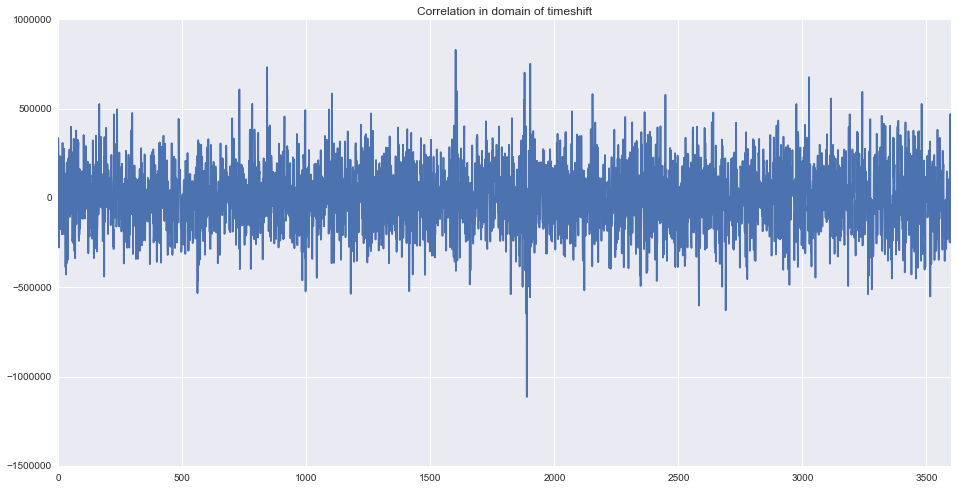

In [11]:
correlation_max_1000 = np.argmax(c_array_1000)
print('Maximum correlation exists in %s time shift' % correlation_max_1000)

pp.plot(np.arange(3600), c_array_1000)
pp.xlim(0, 3600)
pp.title('Correlation in domain of timeshift')
pp.show()

Maximum correlation exists with `1891` seconds of time shift, which is roughly 31 minutes and 52 seconds. With NeuroOn timestamps showing 28 minutes and 48 seconds of time difference between the starts of both signals, we should investigate this result further by running cross-correlation with **[assumption]** `25ms` instead of `1s` timeshift. Let's focus on the area around our previous result, **[assumption]** between 1886 and 1896 secods shifted.

In [12]:
samples_per_10_s_25hz = int(1000. / 25 * 10) 

c_array_25 = correlate_with_time_shift(
    c_upsampled_neuroon, c_upsampled_psg,
    max_shift=samples_per_10_s_25hz,
    time_shift=(correlation_max_1000 - 5),
    samples_per_second=40
)

Maximum correlation exists in 1605.4 s time shift


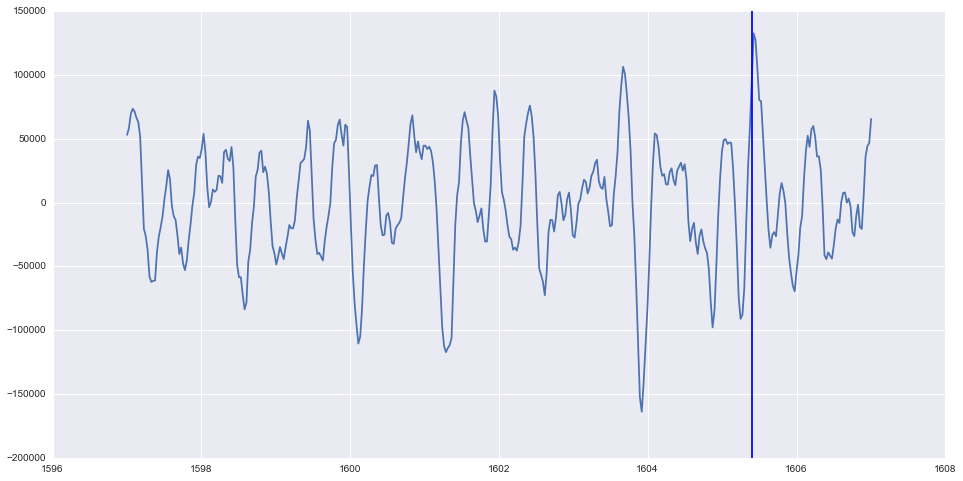

In [13]:
correlation_max_25 = np.argmax(c_array_25)
correlation_max_25_s = correlation_max_25 * 0.025 + (correlation_max_1000 - 5)
print('Maximum correlation exists in %s s time shift' % correlation_max_25_s)

c_25_x_axis = np.linspace(
    correlation_max_1000 - 5,
    correlation_max_1000 + 5,
    samples_per_10_s_25hz
)
pp.plot(c_25_x_axis, c_array_25)
pp.axvline(correlation_max_1000 - 5 + correlation_max_25 * 0.025)
pp.show()

**TODO**: Correlation doesn't serve much purpose without some kind of statistical analysis if it's significant enough.

Nevertheless, let's try to shift NeuroOn's signal and see some samples:

In [14]:
no_signal_shifted = neuroon_signal.copy(deep=True)

no_signal_shifted.timestamp += timedelta(seconds=correlation_max_25_s)

no_signal_shifted[:1]

,timestamp,signal
0,2016-06-20 22:27:45.400000+02:00,-32.768


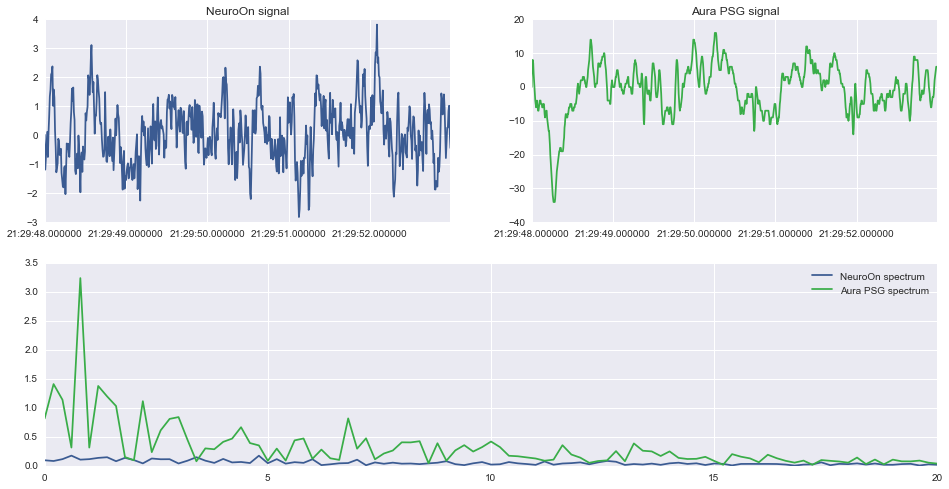

In [15]:
libp.plot_spectrum_fragment(
    no_signal_shifted, psg_signal,
    shift=3600,
    seconds=5,
    cap_frequency=20,
)

In [16]:
correlation_1_array, correlation_1_max = libt.find_max_correlation(
    neuroon_signal,
    psg_signal,
    signal_start=timedelta(hours=1),
    window_shift=timedelta(hours=1),
    window_length=timedelta(hours=1),
)

In [17]:
correlation_2_array, correlation_2_max = libt.find_max_correlation(
    neuroon_signal,
    psg_signal,
    signal_start=timedelta(hours=2),
    window_shift=timedelta(hours=1),
    window_length=timedelta(hours=1),
)

In [18]:
correlation_3_array, correlation_3_max = libt.find_max_correlation(
    neuroon_signal,
    psg_signal,
    signal_start=timedelta(hours=3),
    window_shift=timedelta(hours=1),
    window_length=timedelta(hours=1),
)

In [19]:
correlation_4_array, correlation_4_max = libt.find_max_correlation(
    neuroon_signal,
    psg_signal,
    signal_start=timedelta(hours=4),
    window_shift=timedelta(hours=1),
    window_length=timedelta(hours=1),
)

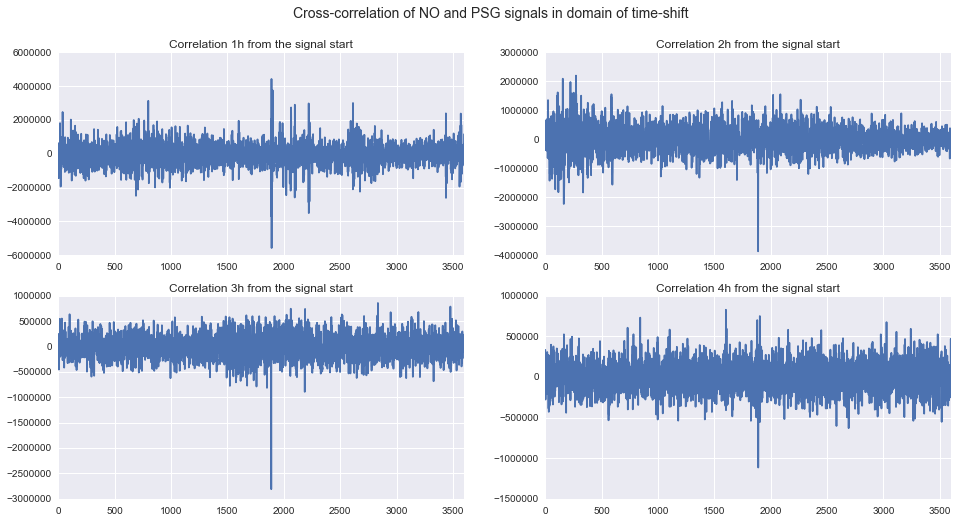

In [20]:
pp.suptitle("Cross-correlation of NO and PSG signals in domain of time-shift", fontsize=14)
pp.subplot(221)
pp.title('Correlation 1h from the signal start')
pp.xlim(0, 3600)
pp.plot(np.arange(3600), correlation_1_array)
pp.subplot(222)
pp.title('Correlation 2h from the signal start')
pp.xlim(0, 3600)
pp.plot(np.arange(3600), correlation_2_array)
pp.subplot(223)
pp.title('Correlation 3h from the signal start')
pp.xlim(0, 3600)
pp.plot(np.arange(3600), correlation_3_array)
pp.subplot(224)
pp.title('Correlation 4h from the signal start')
pp.xlim(0, 3600)
pp.plot(np.arange(3600), correlation_4_array)
pp.show()

In [21]:
print(np.argmin(correlation_1_array))
print(np.argmin(correlation_2_array))
print(np.argmin(correlation_3_array))
print(np.argmin(correlation_4_array))

1892
1888
1889
1889


Cross-correlation of the signals doesn't seem to have a stable maximum point depending on the position of the signal taken (1 to 4 h from the original NO signal's start). It does seem to have a clear minimal point around `1889`. 

## Spectrograms and spectrogram correlations

In [86]:
# WIP, a lot of WIP
# Get spectrograms of NeuroOn and PSG with the same size of time window t_d=5s

s_sample_length = timedelta(hours=2)

# Let's take a piece of signal one hour in, with less muscle artifacts
s_signal_shift = timedelta(hours=1)

s_neuroon_time_window = np.logical_and(
    neuroon_signal['timestamp'] > neuroon_signal['timestamp'][0] + c_signal_shift,
    neuroon_signal['timestamp'] <= neuroon_signal['timestamp'][0] + c_signal_shift + c_sample_length
)
s_neuroon_signal = neuroon_signal[c_neuroon_time_window]

s_psg_time_window = np.logical_and(
    psg_signal['timestamp'] > psg_signal['timestamp'][0] + c_signal_shift,
    psg_signal['timestamp'] <= psg_signal['timestamp'][0] + c_signal_shift + c_sample_length
)
s_psg_signal = psg_signal[c_psg_time_window]

In [87]:
s_no_freq, s_no_time, s_no_spectrogram = signal.spectrogram(
    x=s_neuroon_signal.signal,
    fs=NEUROON_SAMPLE_RATE,
    nperseg=NEUROON_SAMPLE_RATE * 5,
)

In [88]:
s_psg_freq, s_psg_time, s_psg_spectrogram = signal.spectrogram(
    x=s_psg_signal.signal,
    fs=PSG_SAMPLE_RATE,
    nperseg=PSG_SAMPLE_RATE * 5
)

In [89]:
print(len(s_psg_spectrogram))
print(len(s_no_spectrogram))

# sns.heatmap(
#     s_psg_spectrogram[:60],
#     vmax=1000,
#     xticklabels=100
# )

501
313


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


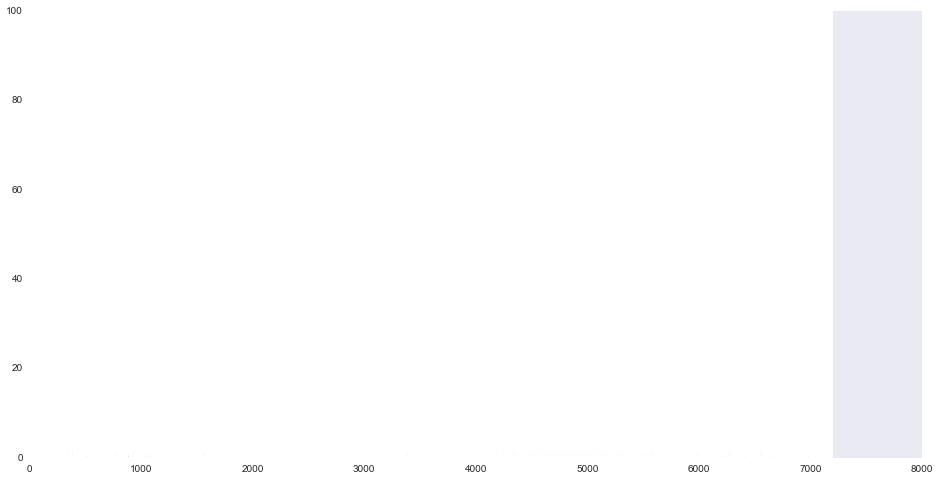

In [81]:
pp.pcolormesh(s_psg_time, s_psg_freq, s_psg_spectrogram)
# pp.xlim(0, 60)
pp.show()

**TODO**:
 - check correlation for other delays
 - check spectrogram
 - [windowing](https://en.wikipedia.org/wiki/Window_function)
 - Fourier binning
 
 
**ONLY DIRTY NOTES BELOW**

In [22]:
# And now something totally different
# Let's get the staging

neuroon_stages = pd.read_csv('night_01/neuroon_stages.csv')
neuroon_stages.drop('Unnamed: 0', 1, inplace=True)
neuroon_stages['timestamp'] = neuroon_stages['timestamp'].astype(int)
neuroon_stages['timestamp'] = pd.to_datetime(neuroon_stages['timestamp'], unit='ms')
neuroon_stages['timestamp'] += timedelta(hours=2)
neuroon_stages[:10]

,stage,timestamp
0,0,2016-06-20 22:01:30
1,0,2016-06-20 22:02:00
2,0,2016-06-20 22:02:30
3,0,2016-06-20 22:03:00
4,0,2016-06-20 22:03:30
5,0,2016-06-20 22:04:00
6,0,2016-06-20 22:04:30
7,0,2016-06-20 22:05:00
8,0,2016-06-20 22:05:30
9,0,2016-06-20 22:06:00


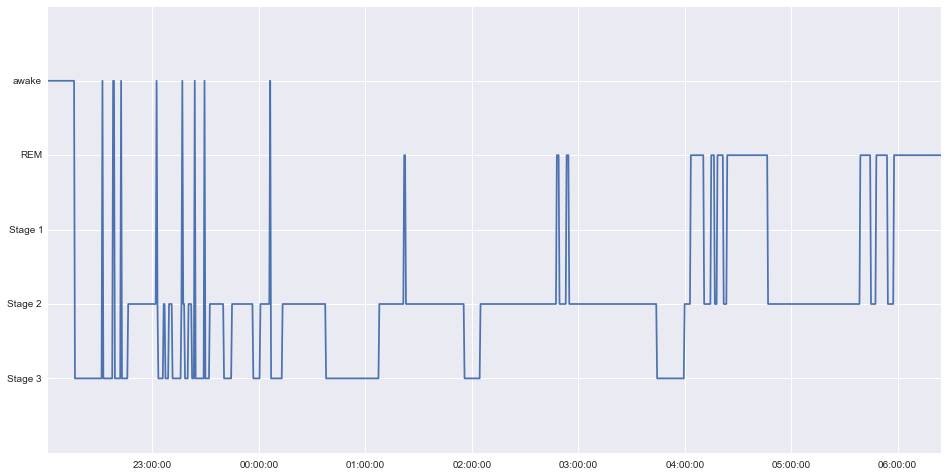

In [23]:
# plotting NeuroOn's stages

pp.plot(neuroon_stages['timestamp'], neuroon_stages['stage'])
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.show()

In [24]:
# get signal from PSG

psg_stages = pd.read_csv('night_01/psg_stages.csv', names=['timestamp', 'raw'])
psg_stages['timestamp'] = psg_stages['timestamp']
psg_stages['timestamp'] = pd.to_datetime(psg_stages['timestamp'], format=' %H:%M:%S.%f')
psg_stages[:10]

# clear the data!

,timestamp,raw
0,1900-01-01 22:29:01.000,Start Recording
1,1900-01-01 22:29:01.000,Nowy montaż - 1-PSG-A1
2,1900-01-01 22:29:36.000,Paused
3,1900-01-01 22:29:48.000,Start Recording
4,1900-01-01 22:29:48.000,Stage - No Stage
5,1900-01-01 22:31:32.500,Kalibracja Start
6,1900-01-01 22:31:48.700,Oczy otwarte
7,1900-01-01 22:31:54.900,Oczy w górę
8,1900-01-01 22:31:59.700,Oczy w dół
9,1900-01-01 22:32:03.100,Oczy w lewo


In [25]:
# fix the date problem, it will be painful for plotting
def split_days(timestamp):
    stage_timedelta = datetime(year=2016, month=6, day=20) - datetime(year=1900, month=1, day=1)
    if timestamp.hour > 12:
        return timestamp + stage_timedelta
    else:
        return timestamp + stage_timedelta + timedelta(days=1)

psg_stages['timestamp'] = psg_stages['timestamp'].apply(split_days)

In [26]:
def clear_psg_stages(stage_desc):
    return {
        'Stage - W': 0,
        'Stage - R': -1,
        'Stage - N1': -2,
        'Stage - N2': -3,
        'Stage - N3': -4,
    }.get(stage_desc, 1)

psg_stages['stage'] = psg_stages['raw'].apply(clear_psg_stages)
psg_stages[100:110]

,timestamp,raw,stage
100,2016-06-20 23:46:11.870,LM - Dur: 0.2 sec. - Periodic,1
101,2016-06-20 23:46:18.000,Stage - N1,-2
102,2016-06-20 23:46:48.000,Stage - N2,-3
103,2016-06-20 23:47:25.350,LM - Dur: 3.1 sec. - Periodic,1
104,2016-06-20 23:47:48.000,Stage - N3,-4
105,2016-06-20 23:48:01.950,LM - Dur: 1.0 sec. - Periodic,1
106,2016-06-20 23:48:48.000,Stage - N2,-3
107,2016-06-20 23:50:48.000,Stage - N3,-4
108,2016-06-20 23:55:11.720,LM - Dur: 1.0 sec. - Periodic,1
109,2016-06-20 23:55:23.490,LM - Dur: 2.8 sec. - Periodic,1


In [27]:
# EXTREMELY FUGLY DO NOT DO THAT JUST FOR TESTS
psg_stages['stage'] = psg_stages['stage'].apply(lambda x: x if x < 1 else None)
new_timestamps = pd.date_range(
    psg_stages.timestamp.min(),
    psg_stages.timestamp.max(),
    freq='30s'
)
new_series = pd.DataFrame(new_timestamps, columns=['timestamp'])
# WARNING: Mutating psg_stages!
psg_stages = pd.merge(psg_stages, new_series, how='outer', on=['timestamp'])
psg_stages = psg_stages.sort_values(['timestamp'])

In [28]:
psg_stages = psg_stages.fillna(method='backfill')
psg_stages[100:110]

,timestamp,raw,stage
487,2016-06-20 23:00:31,Stage - N1,-2
488,2016-06-20 23:01:01,Stage - N1,-2
489,2016-06-20 23:01:31,Stage - N1,-2
490,2016-06-20 23:02:01,Stage - N1,-2
491,2016-06-20 23:02:31,Stage - N1,-2
492,2016-06-20 23:03:01,Stage - N1,-2
38,2016-06-20 23:03:18,Stage - N1,-2
493,2016-06-20 23:03:31,Stage - W,0
494,2016-06-20 23:04:01,Stage - W,0
39,2016-06-20 23:04:18,Stage - W,0


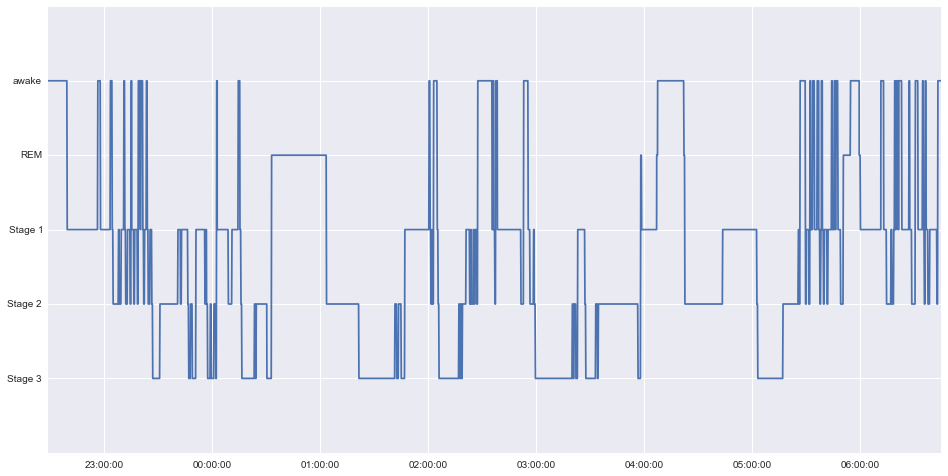

In [29]:
pp.plot(psg_stages['timestamp'], psg_stages['stage'])
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.show()

In [30]:
# TODO: Add missing date points
# psg_stages[psg_stages['timestamp'] > datetime(year=2016, month=6, day=21, hour=0, minute=30)]

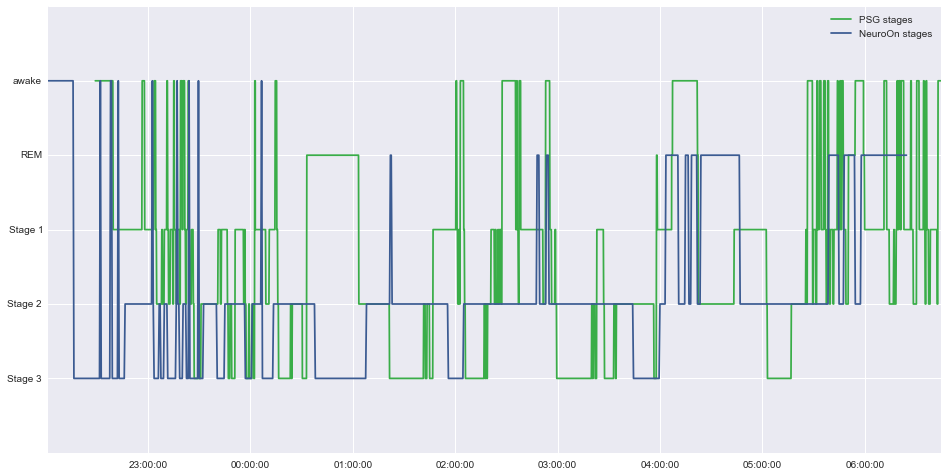

In [31]:
# finally, PSG / Neuroon

psg_stages_graph = pp.plot(
    psg_stages['timestamp'],
    psg_stages['stage'],
    sns.xkcd_rgb['medium green'],
    label='PSG stages'
)
neuroon_stages_graph = pp.plot(
    neuroon_stages['timestamp'],
    neuroon_stages['stage'],
    sns.xkcd_rgb['denim blue'],
    label='NeuroOn stages'
)
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.legend()
pp.show()

I will need to clean that up.

Special thanks to: Bartosz Król, [Jarek Hirniak](http://hirniak.com/), Adam Goliński, Karolina Stosio